In [138]:
import pandas as pd
import json
import os
import numpy as np
import time
import ipywidgets as widgets
from bqplot import *
import qgrid

pd.options.display.max_columns = 999


import matplotlib.pyplot as plt
from matplotlib.patches import Arc

from mplsoccer import Pitch, VerticalPitch, add_image, FontManager
import seaborn as sns
from matplotlib import rcParams
import math
from PIL import Image

from highlight_text import ax_text
from matplotlib import animation
hfont = {'fontname':'Georgia'}

from scipy import optimize as op
from scipy.spatial import ConvexHull

from collections import Counter

from itertools import chain
import seaborn as sn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools


In [17]:
with open('data/all_games_active.json', 'r') as json_file:
    all_games = json.load(json_file)

In [19]:
with open('data/corner_timeelapsed_store.json', 'r') as json_file:
    corner_timeelpased_store = json.load(json_file)

In [25]:
ix = 0
avg_cal = 0
starting_coor = 0

for file_name in all_games.keys():
    for corner_num in all_games[file_name].keys():
        
        try:
            avg_cal += len(np.array(all_games[file_name][corner_num]['attacking_coors'])[starting_coor])
            ix +=1
        except ValueError as ve:
            avg_cal += len(np.array([sublist for sublist in all_games[file_name][corner_num]['attacking_coors'] if sublist])[starting_coor])
            ix +=1
            
print("Avg. number of attackers per frame - ", avg_cal / ix)

Avg. number of attackers per frame -  5.617834394904459


In [40]:
def_type = pd.read_csv('data/dtype.csv')

In [41]:
def_type.head()

,Unnamed: 0,cost,zone_markers,attackers_in_six_yard,file_name_entry,cluster,cluster_single_feature,kmeans_single_feature,gmm_all,gmm_single,kmeans_single
0,0,6.370,3,1,0.json_0,0,0,0,Man-Mark,Man-Mark,Man-Mark
1,1,7.343,3,2,0.json_1,0,0,0,Man-Mark,Man-Mark,Man-Mark
2,2,13.322,4,2,0.json_2,0,1,0,Man-Mark,Zone,Man-Mark
3,3,8.063,2,0,0.json_3,0,0,0,Man-Mark,Man-Mark,Man-Mark
4,4,7.703,2,0,0.json_4,0,0,0,Man-Mark,Man-Mark,Man-Mark


In [144]:
acc_list = []
speed_list = []
corner_type_list = []
corner_sequence_list = []
above_2 = []

for file_name in all_games.keys():
    counter = 0
    for corner_num in all_games[file_name].keys():

        try:
            ball_coors = np.array(all_games[file_name][corner_num]['ball_coors'])
            attacking_coors = np.array(all_games[file_name][corner_num]['attacking_coors'])
            

        except ValueError as ve:
        
            ball_coors = np.array([sublist for sublist in all_games[file_name][corner_num]['ball_coors'] if sublist])
            attacking_coors = np.array([sublist for sublist in all_games[file_name][corner_num]['attacking_coors'] if sublist])

        index_below_64 = 50
                
        if ball_coors[index_below_64][0][1] < 55:
            index_below_64 = 37


        index_below_44 = index_below_64 + 25
        #1 second after the ball crosses 64
        if index_below_44 > len(ball_coors):
            index_below_44 = len(ball_coors)
        

        each_frame_above_threshold = 0
        for value in attacking_coors[index_below_64:index_below_44+1]:
            each_frame = []
            
            for i in range(len(value)):
                acc_list.append(value[i][3])
                speed_list.append(value[i][2])
                each_frame.append(value[i][2])
        
            #the logic is based on the below speed_list histogram -: players with speed more than the mean speed seen
            each_frame_above_threshold = max(each_frame_above_threshold, len([element for element in each_frame if element > 2.8]))

        above_2.append(each_frame_above_threshold)
        
        
        _, _, _, _, _, corner_type, sequence = corner_timeelpased_store[file_name][counter]
        corner_type_list.append(corner_type)
        corner_sequence_list.append(sequence.split("> ")[-1])
        counter +=1
        

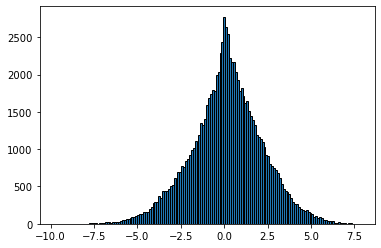

In [145]:
plt.hist(acc_list, bins='auto', edgecolor='black')  # 'auto' determines the number of bins automatically
plt.show()

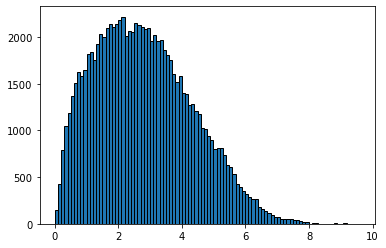

In [146]:
plt.hist(speed_list, bins='auto', edgecolor='black')  # 'auto' determines the number of bins automatically
plt.show()

In [147]:
print("mean", np.mean(speed_list))
print("Std", np.std(speed_list))

mean 2.801699329415461
Std 1.5275148759473742


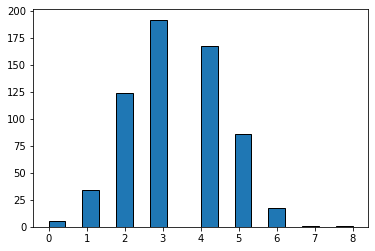

In [148]:
plt.hist(above_2, bins='auto', edgecolor='black')  # 'auto' determines the number of bins automatically
plt.show()

In [152]:
Counter(above_2)

Counter({3: 192, 4: 168, 5: 86, 6: 17, 2: 124, 1: 34, 0: 5, 8: 1, 7: 1})

In [160]:
dynamic_movement = [1 if ele > 2 else 0 for ele in above_2]

In [153]:
len([element for element in above_2 if element > 2])

465

In [163]:
def_type['above_2'] = above_2
def_type['dynamic_movement'] = dynamic_movement

def_type['corner_sequence_list'] = corner_sequence_list
def_type['corner_type_list'] = corner_type_list

In [167]:
Counter(corner_sequence_list)

Counter({'Clearance': 348,
         'Claim': 22,
         'Out': 26,
         'Ball touch': 1,
         'Attempt Saved': 59,
         'Miss': 100,
         'Pass': 16,
         'Corner Awarded': 7,
         'Ball recovery': 6,
         'Goal': 11,
         'Foul': 16,
         'Deleted event': 2,
         'Aerial': 2,
         'Keeper pick-up': 6,
         'Take On': 2,
         'Offside Pass': 4})

In [202]:
shots = ['Attempt Saved', 'Miss', "Goal"]

shots_attempt = [1 if ele in shots else 0 for ele in corner_sequence_list]

In [173]:
def_type['shots_attempt'] = shots_attempt

In [180]:
def_type['attack_setup'] = list(pd.read_csv('att_clusters.csv')['cluster'])

In [205]:
corner_detail = [0 if ele == 'Inswinger' else 1 for ele in list(def_type['corner_type'])]
def_type['corner_detail'] = corner_detail

In [206]:
def_type = def_type.rename(columns={"corner_type_list": "corner_type", 'shots_attempt': 'shot_attempt','cluster': 'defense_type','gmm_all':'def_detail'})

In [208]:
features = def_type[['defense_type', 'def_detail','corner_type', 'corner_detail','dynamic_movement', 'shot_attempt','attack_setup']]

In [210]:
# features.to_csv('data/features.csv', index=False)

[ 0.56981398  2.36762862 -0.24936016 -1.52302619  2.67140167 -2.21354266] [-0.11095393  2.06348792  4.06592336  3.03286553  0.60865793  4.01438125]


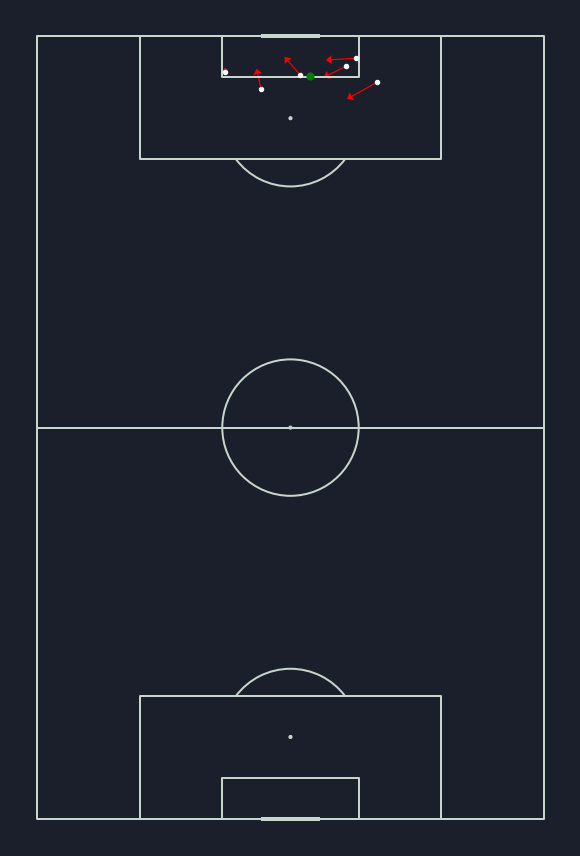

In [37]:
#to visualize speeds

start_xy = []
file_names = []
corner_id_list_start = []
player_location_list_start = []



pitch = VerticalPitch(pitch_color='#1b1f2b',pitch_type='custom',
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(14, 12))
fig.set_facecolor('#1b1f2b')

starting_coor = -1



for file_name in ['0.json']:
    


    corner_num = "1"
        
    file_names.append(file_name + "_" + corner_num)
    try:
        x, y, _,_,speed_x,speed_y = np.array(all_games[file_name][corner_num]['attacking_coors'])[starting_coor][:, :6].T
        start_xy.append((x,y))

        ball_x, ball_y = np.array(all_games[file_name][corner_num]['ball_coors'])[starting_coor][:, :2].T
        print(speed_x,speed_y)
        pitch.scatter(ball_x,ball_y, marker = 'o',ax=ax,zorder=3,s=50, color = "green")


        for idx in range(len(x)):
            
            player_location_list_start.append((x[idx], y[idx]))
            pitch.scatter(x[idx],y[idx], marker = 'o',ax=ax,zorder=3,s=20, color = "white")
            
            ax.quiver(y[idx],x[idx], speed_y[idx], speed_x[idx], color="red", angles='xy', scale_units='xy', scale=1,width=0.002,headlength=5,headwidth=8)
            
            corner_id_list_start.append(str(file_name) + "_" + str(corner_num))


    except ValueError as ve:

        x, y = np.array([sublist for sublist in all_games[file_name][corner_num]['attacking_coors'] if sublist])[starting_coor][:, :2].T
        start_xy.append((x,y))
        
        pitch.scatter(x,y, marker = 'o',ax=ax,zorder=3,s=20, color = "yellow")
        
        for idx in range(len(x)):
            player_location_list_start.append((x[idx], y[idx]))
            corner_id_list_start.append(str(file_name) + "_" + str(corner_num))

pt.show()

